# Testing LSTM
1. Variasi jumlah layer LSTM
2. Variasi jumlah unit per layer
3. Perbandingan layer LSTM Unidirectional vs Bidirectional

In [9]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.api.layers import Embedding, LSTM, Bidirectional,Dropout, Dense, TextVectorization
from keras.api.models import Sequential
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

In [10]:
# Load data
data = pd.read_csv('../datasets/NusaX-Sentiment-Indonesian/train.csv')
data_valid = pd.read_csv('../datasets/NusaX-Sentiment-Indonesian/valid.csv')

# Extract texts and labels
texts = data['text'].values
texts_valid = data_valid['text'].values

# Configure TextVectorization
tokenizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
tokenizer.adapt(texts)

# Process texts
tokenized_texts = tokenizer(texts)
tokenized_texts_valid = tokenizer(texts_valid)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'].values)
labels_valid = label_encoder.transform(data_valid['label'].values)

In [11]:
def create_model_multiple_layers(n_layers, units_per_layer=32):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128)
    ])
    
    for _ in range(n_layers):
        model.add(LSTM(units_per_layer, return_sequences=True))
        model.add(Dropout(0.2))
    
    # Last LSTM layer should not return sequences
    model.add(LSTM(units_per_layer))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def create_model_varying_units(units_per_layer):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),
        LSTM(units_per_layer[0], return_sequences=True),
        Dropout(0.2),
        LSTM(units_per_layer[1]),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def create_model_directional(bidirectional=False, units=32):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128)
    ])
    
    if bidirectional:
        model.add(Bidirectional(LSTM(units)))
    else:
        model.add(LSTM(units))
    
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(model, model_name):
    # Train dan evaluate sebuah model
    # return (history, f1_score)
    history = model.fit(
        tokenized_texts, labels,
        validation_data=(tokenized_texts_valid, labels_valid),
        epochs=15,
        verbose=0
    )
    
    predictions = model.predict(tokenized_texts_valid)
    predicted_classes = predictions.argmax(axis=1)
    
    f1 = f1_score(labels_valid, predicted_classes, average='macro')
    
    print(f'\nModel: {model_name}')
    print(f'Macro F1-Score: {f1:.4f}')
    
    return history, f1

def plot_training_history(histories, model_names, title):
    # Plot training dan validation loss dalam dua subplot terpisah
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    for history, name in zip(histories, model_names):
        ax1.plot(history.history['loss'], label=name)
    
    ax1.set_title(f'{title}\nTraining Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot validation loss
    for history, name in zip(histories, model_names):
        ax2.plot(history.history['val_loss'], label=name)
    
    ax2.set_title(f'{title}\nValidation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## 1. Variasi jumlah layer LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step

Model: 1 LSTM Layer(s)
Macro F1-Score: 0.1836
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step

Model: 2 LSTM Layer(s)
Macro F1-Score: 0.1836
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step

Model: 3 LSTM Layer(s)
Macro F1-Score: 0.1836


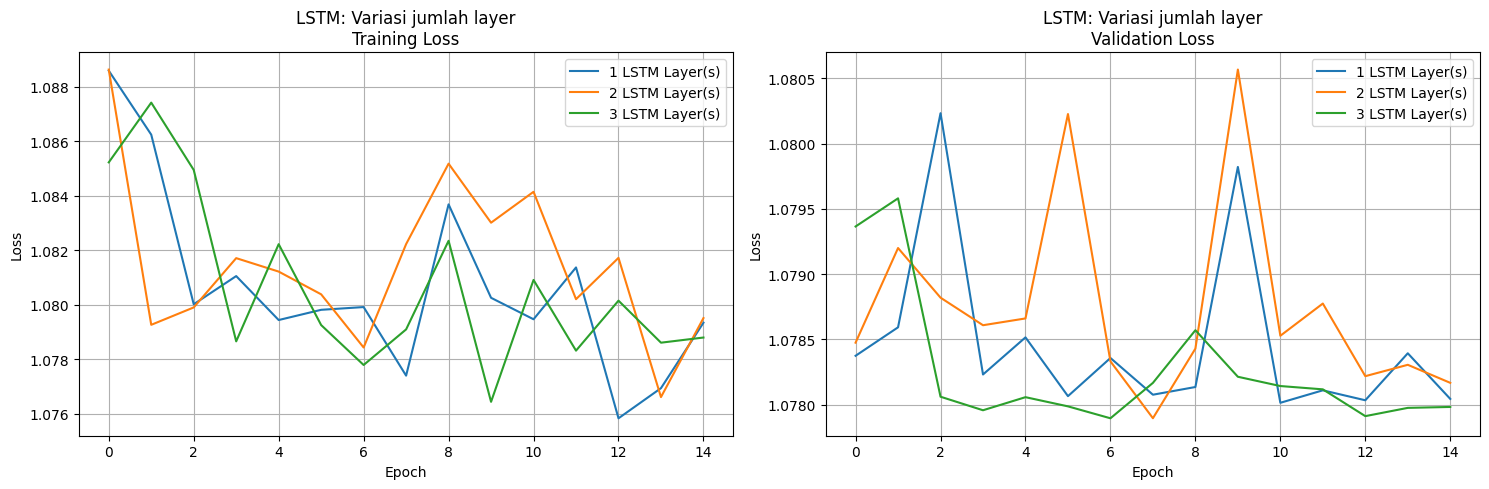

In [12]:
# Create and train models with different numbers of layers
layer_variations = [1, 2, 3]
histories_layers = []
f1_scores_layers = []
model_names_layers = []

for n_layers in layer_variations:
    model_name = f'{n_layers} LSTM Layer(s)'
    model = create_model_multiple_layers(n_layers)
    history, f1 = train_and_evaluate(model, model_name)
    
    histories_layers.append(history)
    f1_scores_layers.append(f1)
    model_names_layers.append(model_name)

# Plot training histories
plot_training_history(
    histories_layers,
    model_names_layers,
    'LSTM: Variasi jumlah layer'
)

## 2. Variasi jumlah unit per layer

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step

Model: Units per layer: [16, 8]
Macro F1-Score: 0.1836
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

Model: Units per layer: [32, 16]
Macro F1-Score: 0.1836
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step

Model: Units per layer: [64, 32]
Macro F1-Score: 0.1836


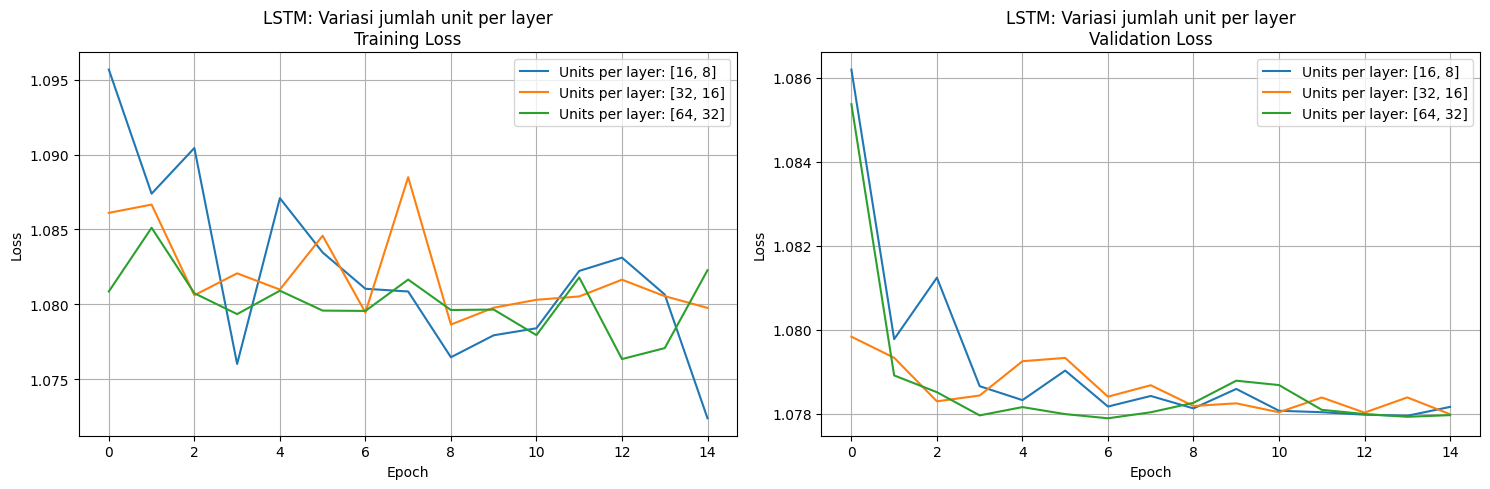

In [13]:
# Create and train models with different units per layer
unit_variations = [
    [16, 8],
    [32, 16],
    [64, 32]
]
histories_units = []
f1_scores_units = []
model_names_units = []

for units in unit_variations:
    model_name = f'Units per layer: {units}'
    model = create_model_varying_units(units)
    history, f1 = train_and_evaluate(model, model_name)
    
    histories_units.append(history)
    f1_scores_units.append(f1)
    model_names_units.append(model_name)

# Plot training histories
plot_training_history(
    histories_units,
    model_names_units,
    'LSTM: Variasi jumlah unit per layer'
)

## 3. Perbandingan layer LSTM Unidirectional vs Bidirectional

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Model: Unidirectional
Macro F1-Score: 0.1836
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

Model: Bidirectional
Macro F1-Score: 0.7636


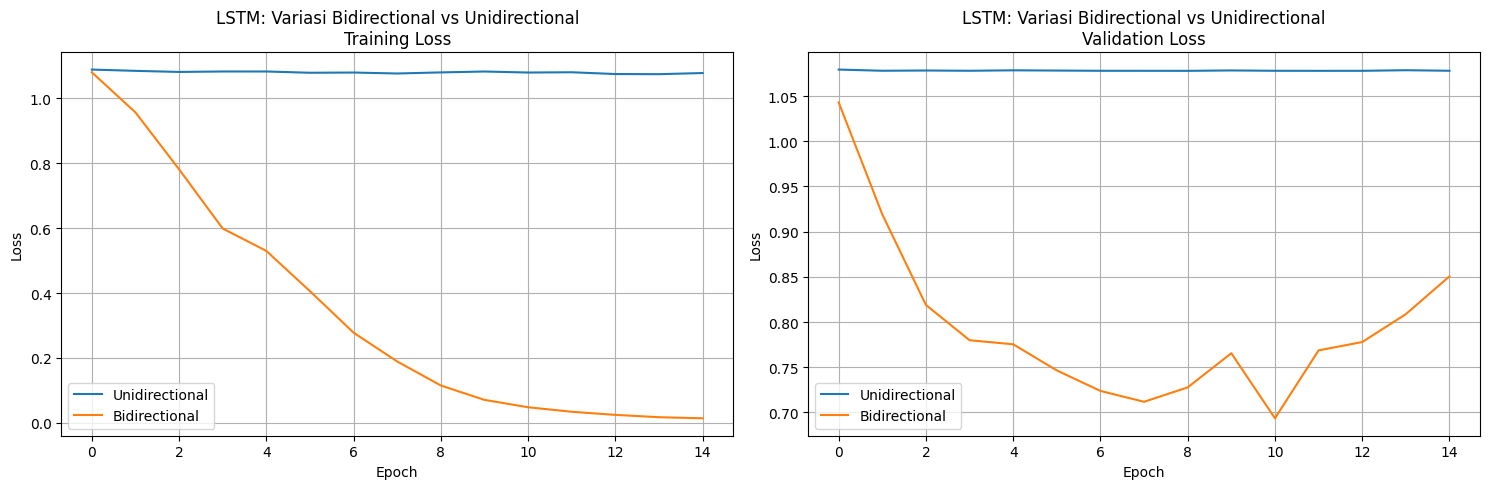

In [14]:
# Create and train models with different LSTM directions
histories_dir = []
f1_scores_dir = []
model_names_dir = []

for is_bidirectional in [False, True]:
    model_name = 'Bidirectional' if is_bidirectional else 'Unidirectional'
    model = create_model_directional(is_bidirectional)
    history, f1 = train_and_evaluate(model, model_name)
    
    histories_dir.append(history)
    f1_scores_dir.append(f1)
    model_names_dir.append(model_name)

# Plot training histories
plot_training_history(
    histories_dir,
    model_names_dir,
    'LSTM: Variasi Bidirectional vs Unidirectional'
)

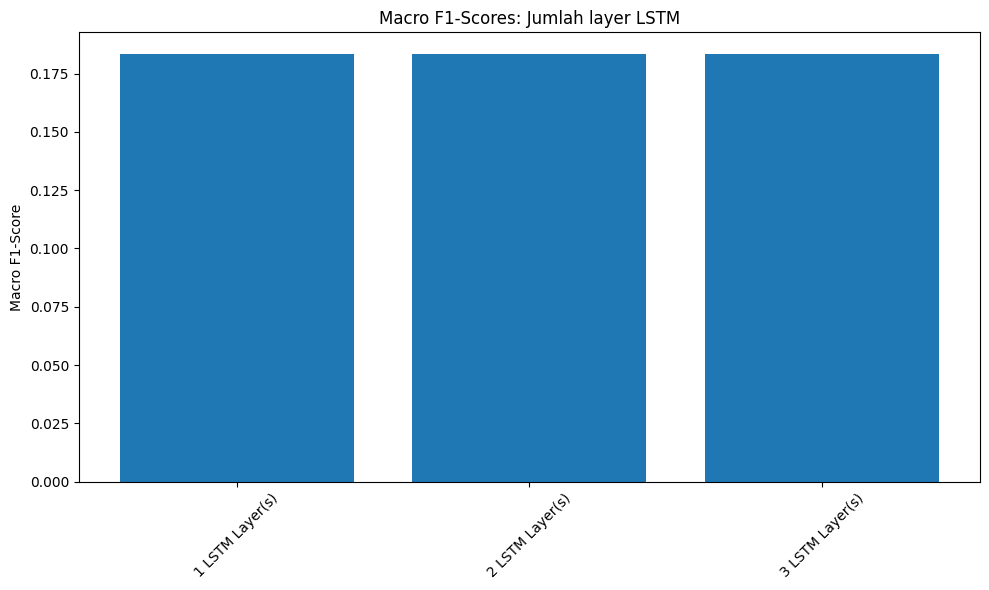

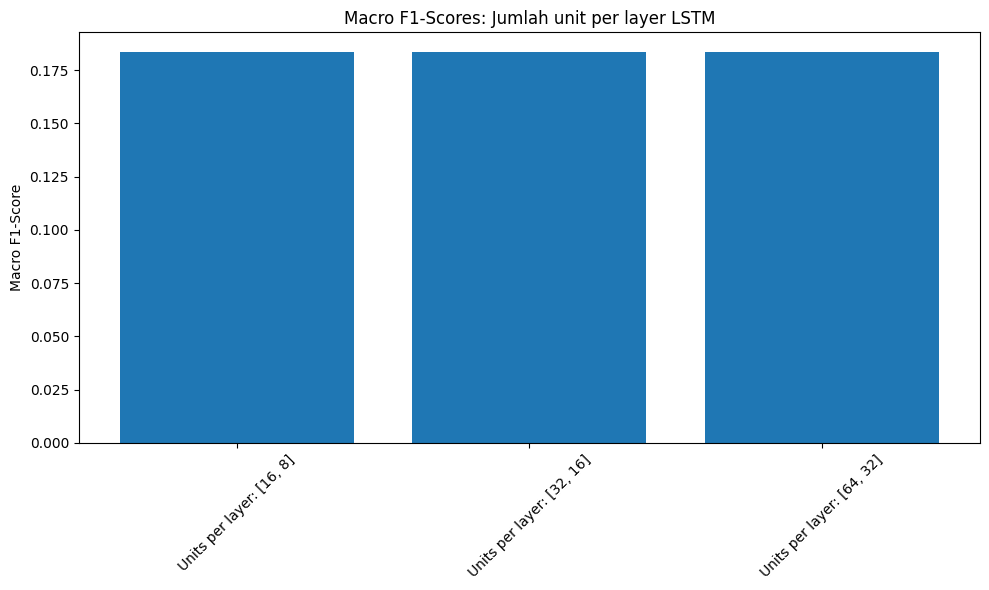

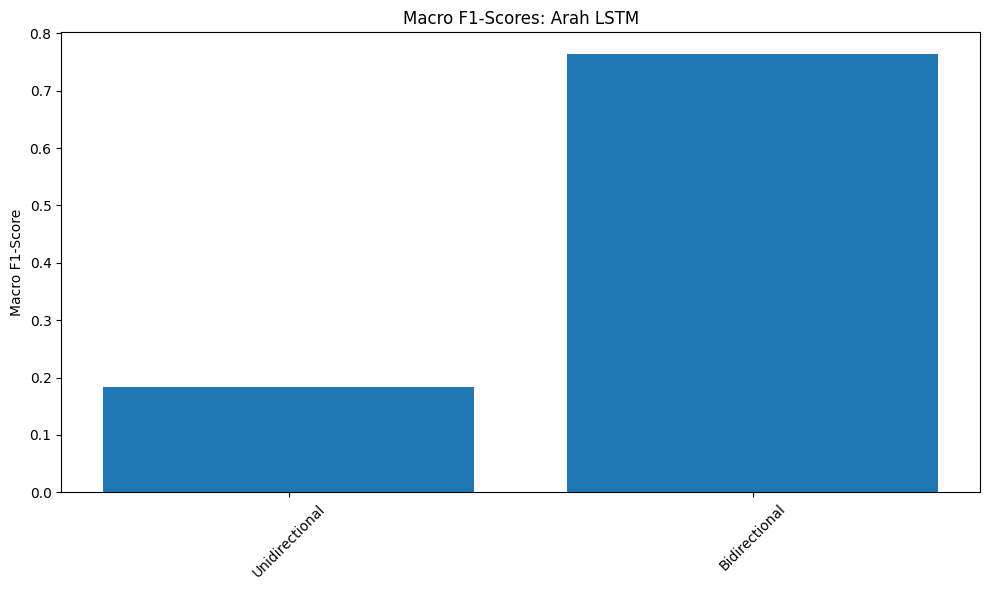

In [15]:
# Final comparison of all models
def plot_f1_scores(scores, names, title):
    plt.figure(figsize=(10, 6))
    plt.bar(names, scores)
    plt.title(f'Macro F1-Scores: {title}')
    plt.xticks(rotation=45)
    plt.ylabel('Macro F1-Score')
    plt.tight_layout()
    plt.show()

# Plot F1 scores for all experiments
plot_f1_scores(f1_scores_layers, model_names_layers, 'Jumlah layer LSTM')
plot_f1_scores(f1_scores_units, model_names_units, 'Jumlah unit per layer LSTM')
plot_f1_scores(f1_scores_dir, model_names_dir, 'Arah LSTM')